In [104]:
%matplotlib inline
import random
random.seed(1234)
from string import punctuation
import pandas as pd
import gzip
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# import nltk
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import spacy
import matplotlib.pyplot as plt
import pyLDAvis #python library for interactive topic model visualization
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")

# import gensim.downloader
# w2v = gensim.downloader.load('word2vec-google-news-300')

# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# import warnings
# warnings.filterwarnings("ignore",category=DeprecationWarning)

import pickle
import numpy as np

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
# import pyLDAvis
# import pyLDAvis.sklearn
# import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm as tqdm
tqdm.pandas()
import math
import nltk
from collections import defaultdict

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
from nltk.probability import FreqDist
from gensim.models.ldamulticore import LdaMulticore
from nltk import tokenize

stop_words = stopwords.words('english')

from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()

from numpy import dot
from numpy.linalg import norm
import random

import itertools

#nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent = SentimentIntensityAnalyzer()

from scipy.spatial.distance import pdist
from scipy.spatial import distance
from scipy.cluster.hierarchy import dendrogram, linkage

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

from nltk.tokenize import sent_tokenize

from sklearn.preprocessing import MinMaxScaler
from nltk import pos_tag

import re

import gensim.downloader
w2v = gensim.downloader.load('word2vec-google-news-300')
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

from sklearn.preprocessing import MinMaxScaler

from scipy.spatial.distance import pdist
from scipy.spatial import distance
from scipy.cluster.hierarchy import dendrogram, linkage

from gensim.models.doc2vec import Doc2Vec, TaggedDocument


# Step1: Read data - cat food

In [2]:
# df = pd.read_csv('./all_df.csv', index_col = False)

In [3]:
with open ('./model/df1.pickle', 'rb') as handle:
    df1 = pickle.load(handle)

In [4]:
# sents = [tokenize.sent_tokenize(str(r)) for r in df1.reviewText.tolist()]
# columns_name = ['Sentence' + str(i) for i in range(1, 31, 1)]
# sents_df1 = pd.DataFrame([sen[:30] for sen in sents], columns = columns_name)

In [5]:
with open ('./model/sents_df1.pickle', 'rb') as handle:
    sents_df1 = pickle.load(handle)

# Step2: Get Attributes

### clean sentences (tokenize, lemmatize)

In [6]:
def clean(sentence, stop_words):
    '''
    Clean sentence. 
            Parameters:
                    sentence (string): A string. 
                    stop_words (list): A list of words to be removed from a sentence. 
                    Lemmatize (boolean): A boolean to indicate whether or not to run lemmatization. . 
                    
            Returns:
                    _ (list): A list of cleaned tokens. 
    '''
    sen0 = ' '.join([word.lower() for word in str(sentence).split() if word.lower() not in stop_words])
    sen1 = sen0.translate(str.maketrans('', '', punctuation))
    tokens1 = [re.sub('[\d.,]' , '', word.lower()) for word in str(sen1).split() if word.lower() not in stop_words]
    sen2 = ' '.join(tokens1)
    tokens1 = [word.lemma_ for word in nlp(sen2)] 
    return tokens1

# def sent_to_words(sentences):
#     '''
#     Simplify and tokenize strings in an iterable.
    
#             Parameters:
#                     sentences (iterable): Review strings in a list or as a pandas.series.
                    
#             Returns:
#                     _ (generator): Simplify review tokens.  
#     '''
#     for sentence in sentences:
#         yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

def get_bigrams(data_words): 
    '''
    Form bigram.
    
        Parameters:
            data_words (iterable): token lists in an iterable. 

        Returns:
           _, _, bigram_pmi (data frame): Bigrams and their pmi scores in a Data Frame. 
    '''
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = nltk.collocations.BigramCollocationFinder.from_documents(data_words) 
    finder.apply_freq_filter(20)
    bigram_scores = finder.score_ngrams(bigram_measures.pmi)
    bigram_pmi = pd.DataFrame(bigram_scores)
    bigram_pmi.columns = ['bigram', 'pmi']
    bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
    
    bigram_scores2 = finder.score_ngrams(bigram_measures.raw_freq)
    bigram_freq = pd.DataFrame(bigram_scores2)
    bigram_freq.columns = ['bigram', 'freq']
    bigram_freq.sort_values(by='freq', axis = 0, ascending = False, inplace = True)

    return finder, bigram_measures, bigram_pmi, bigram_freq

def bigram_filter(bigram):
    """
    Filter bigram. 
        
        Parameters:
            bigram (string): A bigram.

        Returns:
           _ (boolean): Decide whether or not to keep the bigram.
    """
    stop_words = stopwords.words('english')   
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']: #we only want adjective + noun
        return False
    if bigram[0] in stop_words or bigram[1] in stop_words: 
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram: 
        return False
    if len(bigram[0]) <= 2 or len(bigram[1]) <= 2:
        return False
    return True

def get_trigrams(data_words): 
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    finder = nltk.collocations.TrigramCollocationFinder.from_documents(data_words) 
    finder.apply_freq_filter(20)
    trigram_scores = finder.score_ngrams(trigram_measures.pmi)

    trigram_pmi = pd.DataFrame(trigram_scores)
    trigram_pmi.columns = ['trigram', 'pmi']
    trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
    
    trigram_scores2 = finder.score_ngrams(trigram_measures.raw_freq)
    trigram_freq = pd.DataFrame(trigram_scores2)
    trigram_freq.columns = ['trigram', 'freq']
    trigram_freq.sort_values(by='freq', axis = 0, ascending = False, inplace = True)

    return finder, trigram_measures, trigram_pmi, trigram_freq

def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    stop_words = stopwords.words('english')
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_words or trigram[-1] in stop_words or trigram[1] in stop_words:
        return False
    if 'n' in trigram or 't' in trigram:
        return False
    if 'PRON' in trigram:
        return False
    if len(trigram[0]) <= 2 or len(trigram[1]) <= 2 and len(trigram[2]) <= 2:
        return False
    return True 

def replace_ngram(x, bigrams, trigrams):
    '''
    Form ngram. 
        
        Parameters:
            bigram (string): a ngrams.

        Returns:
           x (string): A connected ngrams with underscore.  
    '''
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

def remove_stopwords(texts, extra_stopwords = []):
    '''
    Remove stopwords in an iterable (string or tokens).

        Parameters:
                texts (iterable): Review strings in a list or as a pandas.series.

        Returns:
                _ (list): Simplify review stirngs without stopwords.  
    '''
    stop_words = stopwords.words('english') + extra_stopwords
    return [[word for word in doc.split() if word not in stop_words] for doc in texts]


def extract_attributes(reviews, stop_words):
    cleaned_tokens = [clean(sen, stop_words = stop_words) for sen in reviews]
    sens = [' '.join(sen) for sen in cleaned_tokens] 
    cleaned_tokens2 = [[token.lemma_ for token in nlp(sen) if token.text not in stop_words] for sen in tqdm(sens)] #different ways to lemmatize

    bifinder, bimeasures, bi_pmi, bi_freq = get_bigrams(tqdm(cleaned_tokens)) 
    tri_finder, tri_measures, tri_pmi, tri_freq = get_trigrams(tqdm(cleaned_tokens))
    
    bifinder, bimeasures, bi_pmi2, bi_freq2 = get_bigrams(tqdm(cleaned_tokens2)) 
    tri_finder, tri_measures, tri_pmi2, tri_freq2 = get_trigrams(tqdm(cleaned_tokens2))
    print('get bigrams.')
    cleaned_bi_pmi = bi_pmi[bi_pmi.progress_apply(lambda bigram: bigram_filter(bigram['bigram']) and bigram.pmi > 5, axis = 1)] 
    cleaned_bi_pmi2 = bi_pmi2[bi_pmi2.progress_apply(lambda bigram: bigram_filter(bigram['bigram']) and bigram.pmi > 5, axis = 1)] 
# 
    print('get trigrams.')
    cleaned_tri_pmi = tri_pmi[tri_pmi.progress_apply(lambda trigram: trigram_filter(trigram['trigram']) and trigram.pmi > 5, axis = 1)]
    cleaned_tri_pmi2 = tri_pmi2[tri_pmi2.progress_apply(lambda trigram: trigram_filter(trigram['trigram']) and trigram.pmi > 5, axis = 1)]

    print('get lemmatized tokens from spacy.')
    tags = [pos_tag(sen) for sen in tqdm(cleaned_tokens2)]
    print('get adjectives.')
    adj_tokens = [t[0] for sen in tags for t in sen if t[1] == 'JJ']
    print('get nouns.')
    noun_tokens = [t[0] for sen in tags for t in sen if t[1] == 'NN']
    print('get verbs.')
    verb_tokens = [t[0] for sen in tags for t in sen if t[1] == 'VB']

    return {
        'cleaned_tokens': cleaned_tokens,
        'cleaned_tokens2': cleaned_tokens2,
        'cleaned_bi_pmi': cleaned_bi_pmi, 
        'cleaned_tri_pmi': cleaned_tri_pmi,
        'cleaned_bi_pmi2': cleaned_bi_pmi2, 
        'cleaned_tri_pmi2': cleaned_tri_pmi2,
        'cleaned_bi_freq': bi_freq, 
        'cleaned_tri_freq': tri_freq,
        'cleaned_bi_freq2': bi_freq2, 
        'cleaned_tri_freq2': tri_freq2,
        'tags': tags,
        'adj_tokens': FreqDist(adj_tokens).most_common(100),
        'noun_tokens': FreqDist(noun_tokens).most_common(100),
        'verb_tokens': FreqDist(verb_tokens).most_common(100)
    }

<>:14: DeprecationWarning: invalid escape sequence \d
<>:14: DeprecationWarning: invalid escape sequence \d
C:\Users\JIATIN~1\AppData\Local\Temp/ipykernel_24616/2337347480.py:14: DeprecationWarning: invalid escape sequence \d
  tokens1 = [re.sub('[\d.,]' , '', word.lower()) for word in str(sen1).split() if word.lower() not in stop_words]


In [7]:
# df1_dict = extract_attributes(tqdm(df1.reviewText.tolist()), stop_words = stop_words)

In [8]:
# with open ('./model/df1_dict.pickle', 'wb') as handle:
#     pickle.dump(df1_dict, handle)

#### load cat food cleaned tokens

In [9]:
with open ('./model/df1_dict.pickle', 'rb') as handle:
    df1_dict = pickle.load(handle)

In [10]:
def to_str(s):
    return '' if s is None else str(s)

In [11]:
remove_words = ['dog',
 'cat',
 'food',
 'bed',
 'litter',
 'product',
 'love',
 'like',
 'well',
 'would',
 'work',
 'toy',
 'great',
 'make',
 'good',
 'time',
 'go',
 'I',
 'little',
 'small',
 'look',
 'try',
 'really',
 'seem',
 'recommend',
 'day',
 'month',
 'year',
 'much',
 'nice' , 
 'old', 
 'able', 
 'first', 
 'happy', 
 'thing', 
 'kitten'
]
extra_stopwords = ["don't", "donnt", "he's", "i'd", "would", "she's", "that's", \
                   "i'm", "can't", "i've", "they're", "we'll", "willn't", \
                   "isn't", "aren't", "wouldn't", "would've", "we've", "ve"] + \
                   ["cat", "food"] + remove_words
stop_words = sorted(list(set(stopwords.words('english')  + extra_stopwords + remove_words))) + \
['cat',
 'eat',
 'get',
 'dry',
 'feed',
 'buy',
 'give',
 'love',
 'find',
 'food',
 'try',
 'use',
 'bag',
 'go',
 'think',
 'wet',
 'know',
 'make',
 'seem',
 'say',
 'year',
 'kitty',
 'high',
 'see',
 'stuff',
 'come',
 'look',
 'keep',
 'want',
 'start',
 'every',
 'less',
 'free',
 'take',
 'need',
 'lot',
 'mix',
 'fancy',
 'many',
 'put',
 'feast',
 'good',
 'coat',
 'bit',
 'new',
 'something',
 'change',
 'case',
 'help',
 'sure',
 'month',
 'open',
 'box',
 'way',
 'bad',
 'big',
 'leave',
 'another',
 'last']

In [12]:
sents_df1 = sents_df1.progress_applymap(lambda x: to_str(x))

  0%|          | 0/835290 [00:00<?, ?it/s]

In [13]:
sents_df1.head()

,Sentence1,Sentence2,Sentence3,Sentence4,Sentence5,Sentence6,Sentence7,Sentence8,Sentence9,Sentence10,...,Sentence21,Sentence22,Sentence23,Sentence24,Sentence25,Sentence26,Sentence27,Sentence28,Sentence29,Sentence30
0,I found these on sale and bought them on a whi...,,,,,,,,,,...,,,,,,,,,,
1,"My kittens were crazy over these, but as they ...",Now I have a new year old cat and he plays fet...,HE will chase it and bring it back as long as ...,He carries them around and plays by himself wi...,I have never seen a cat so crazy over a toy.,"I have ten of them, but can usually only find ...",He always seems to locate one when he wants one.,I think they are a little overpriced for littl...,,,...,,,,,,,,,,
2,My cat absolutely loves spinners!,She carries them around in her mouth when she ...,By far her favorite toy!,,,,,,,,...,,,,,,,,,,
3,these were TINY and made out of very lightweig...,"i gave one to my cat and in under a minute, sh...",STAY AWAY.,,,,,,,,...,,,,,,,,,,
4,I bought this cat toy thinking that I would us...,"I haven't made my own parakeet toys yet, so I ...","Then this evening, on the spur of the moment, ...",They have been a huge hit - I put them in abou...,"He picks them up, moves them around, drops the...",What a riot.,,,,,...,,,,,,,,,,


In [72]:
sents_df1['Sentence1_tokens'] = sents_df1.Sentence1.progress_apply(lambda x:clean(x, stop_words = stop_words))

  0%|          | 0/27843 [00:00<?, ?it/s]

In [73]:
sents_df1['Sentence2_tokens'] = sents_df1.Sentence2.progress_apply(lambda x:clean(x, stop_words = stop_words))

  0%|          | 0/27843 [00:00<?, ?it/s]

In [74]:
sents_df1['Sentence1_tokens'].head()

0    [find, sale, buy, whim, kitten, omg, go, nuts,...
1               [kittens, crazy, grow, pay, attention]
2                     [cat, absolutely, love, spinner]
3                   [tiny, make, lightweight, plastic]
4    [buy, cat, toy, thinking, would, use, spinner,...
Name: Sentence1_tokens, dtype: object

In [75]:
sents_df1['Sentence2_tokens'].head()

0                                                   []
1                   [new, year, old, cat, play, fetch]
2          [carry, around, mouth, toss, around, chase]
3    [give, one, cat, minute, chewed, ball, tip, ch...
4    [make, parakeet, toy, yet, vacillate, kind, st...
Name: Sentence2_tokens, dtype: object

In [17]:
sents_df1['Sentence2_tokens'] = sents_df1.Sentence2.progress_apply(lambda x:clean(x, stop_words = stop_words))
sents_df1['Sentence3_tokens'] = sents_df1.Sentence3.progress_apply(lambda x:clean(x, stop_words = stop_words))
sents_df1['Sentence4_tokens'] = sents_df1.Sentence4.progress_apply(lambda x:clean(x, stop_words = stop_words))
sents_df1['Sentence5_tokens'] = sents_df1.Sentence5.progress_apply(lambda x:clean(x, stop_words = stop_words))
sents_df1['Sentence6_tokens'] = sents_df1.Sentence6.progress_apply(lambda x:clean(x, stop_words = stop_words))
sents_df1['Sentence7_tokens'] = sents_df1.Sentence7.progress_apply(lambda x:clean(x, stop_words = stop_words))
sents_df1['Sentence8_tokens'] = sents_df1.Sentence8.progress_apply(lambda x:clean(x, stop_words = stop_words))
sents_df1['Sentence9_tokens'] = sents_df1.Sentence9.progress_apply(lambda x:clean(x, stop_words = stop_words))
sents_df1['Sentence10_tokens'] = sents_df1.Sentence10.progress_apply(lambda x:clean(x, stop_words = stop_words))
sents_df1['Sentence11_tokens'] = sents_df1.Sentence11.progress_apply(lambda x:clean(x, stop_words = stop_words))
sents_df1['Sentence12_tokens'] = sents_df1.Sentence12.progress_apply(lambda x:clean(x, stop_words = stop_words))
sents_df1['Sentence13_tokens'] = sents_df1.Sentence13.progress_apply(lambda x:clean(x, stop_words = stop_words))
sents_df1['Sentence14_tokens'] = sents_df1.Sentence14.progress_apply(lambda x:clean(x, stop_words = stop_words))
sents_df1['Sentence15_tokens'] = sents_df1.Sentence15.progress_apply(lambda x:clean(x, stop_words = stop_words))
sents_df1['Sentence16_tokens'] = sents_df1.Sentence16.progress_apply(lambda x:clean(x, stop_words = stop_words))
sents_df1['Sentence17_tokens'] = sents_df1.Sentence17.progress_apply(lambda x:clean(x, stop_words = stop_words))
sents_df1['Sentence18_tokens'] = sents_df1.Sentence18.progress_apply(lambda x:clean(x, stop_words = stop_words))
sents_df1['Sentence19_tokens'] = sents_df1.Sentence19.progress_apply(lambda x:clean(x, stop_words = stop_words))
sents_df1['Sentence20_tokens'] = sents_df1.Sentence20.progress_apply(lambda x:clean(x, stop_words = stop_words))
sents_df1['Sentence21_tokens'] = sents_df1.Sentence21.progress_apply(lambda x:clean(x, stop_words = stop_words))
sents_df1['Sentence22_tokens'] = sents_df1.Sentence22.progress_apply(lambda x:clean(x, stop_words = stop_words))
sents_df1['Sentence23_tokens'] = sents_df1.Sentence23.progress_apply(lambda x:clean(x, stop_words = stop_words))
sents_df1['Sentence24_tokens'] = sents_df1.Sentence24.progress_apply(lambda x:clean(x, stop_words = stop_words))
sents_df1['Sentence25_tokens'] = sents_df1.Sentence25.progress_apply(lambda x:clean(x, stop_words = stop_words))
sents_df1['Sentence26_tokens'] = sents_df1.Sentence26.progress_apply(lambda x:clean(x, stop_words = stop_words))
sents_df1['Sentence27_tokens'] = sents_df1.Sentence27.progress_apply(lambda x:clean(x, stop_words = stop_words))
sents_df1['Sentence28_tokens'] = sents_df1.Sentence28.progress_apply(lambda x:clean(x, stop_words = stop_words))
sents_df1['Sentence29_tokens'] = sents_df1.Sentence29.progress_apply(lambda x:clean(x, stop_words = stop_words))
sents_df1['Sentence30_tokens'] = sents_df1.Sentence30.progress_apply(lambda x:clean(x, stop_words = stop_words))

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

In [18]:
with open ('./sents_df1.pickle', 'wb') as handle:
    pickle.dump(sents_df1, handle)

### combine feature list from top nouns, adjective, and ngram pharses. 

In [21]:
keep_indexes = [6, 7, 8, 21, 23, 24, 26, 29, 30, 33, 35, 38, 68, 70, 75] #8? 
df1_dict['cleaned_bi_pmi2'].iloc[keep_indexes] # feature list 1
feature_lst1 = df1_dict['cleaned_bi_pmi2'].iloc[keep_indexes]['bigram'].tolist()

In [22]:
keep_indexes = [4, 8, 15, 28, 32, 38, 39, 65, 75, 76, 119] 
df1_dict['cleaned_bi_freq2'].iloc[keep_indexes]
feature_lst2 = df1_dict['cleaned_bi_freq2'].iloc[keep_indexes]['bigram'].tolist()

In [23]:
retain_indexes = [47, 48, 53, 78]
feature_lst3 = df1_dict['cleaned_tri_pmi2'].iloc[retain_indexes]['trigram'].tolist()

In [24]:
df1_dict['cleaned_tri_freq2'] = df1_dict['cleaned_tri_freq2'].reset_index(drop = True)
retain_indexes = [27, 17, 33, 34, 39, 41]
feature_lst4 = df1_dict['cleaned_tri_freq2'].iloc[retain_indexes]['trigram'].tolist()

In [25]:
[t[0] for t in df1_dict['noun_tokens']]

feature_lst5 =  \
['brand',
 'flavor',
 'price',
 'ingredient',
 'quality',
 'chicken',
 'order',
 'variety',
 'grain',
 'meat',
 'smell',
 'formula',
 'treat',
 'taste',
 'wellness',
 'health',
# 'weight',
 'pack',
 'protein',
 'tuna',
 'science',
 'balance',
 'cost',
 'size',
 'friskie', #fresh
 'corn',
 'money',
 'turkey',
 'salmon',
 'amount',
 'byproduct',
 'beef',
 'ship',
 'care',
 'choice',
 'contain',
 'rice',
 'nutrition',
 'vitamin',
 'gravy',
 'chunk',
 'prescription',
 'waste']

In [26]:
[t[0] for t in df1_dict['adj_tokens']]

feature_lst6 = ['healthy',
 'expensive',
 'natural',
 'different',
 'cheap',
 'fish',
 'several',
 'kibble',
 'ingredient',
 'gravy',
 'organic',
 'fresh',
 'grainfree',
 'salmon',
 'nutritional',
'diabetic',
 'vegetable']

In [27]:
feature_lst = feature_lst1 +feature_lst2 + feature_lst3 + feature_lst4 + feature_lst5 + feature_lst6

In [28]:
total_features = [
 'amount',
 #'balance',
 'beef',
 #'brand',
 'break bank',
 'byproduct',
 'calcium carbonate',
 # 'calcium iodate', #?????????????????
 'cheap',
 'chicken',
 #'choice',
 'choline chloride',
# 'chunk',
 #'balanced nutrition',
 'corn',
 'cost',
# 'deliver front door',
# 'diabetic',
 'different flavor',
 'diversity flavor choose',
 'expensive',
 'fatty acids',
 'ferrous sulfate',
 'fish',
 'flavor',
 'folic acid',
 'formula',
#  'fresh',
 #'friske',
 'grain',
 'gravy',
 'health',
 'ingredient',
 'kibble',
 'low carb', #adj + noun
 'meat',
 'money',
#  'natural',
#  'natural balance',
 'nutrition',
 'ocean whitefish', #noun + noun
# 'order',
 'organic',
 'pack',
 'powdered cellulose',
#  'prescription',
 'price',
 'protein',
 'pyridoxine hydrochloride',
 'quality',
  'rice',
 'salmon',
 'save money',
 'several',
# 'ship',
#  'size',
#  'smell',
 'sodium bisulfate',
 'sodium bisulfite',
 'subscribe save',
 'subscribe save option',
 'subscribe save program',
 'taste',
 'taste wild',
 'thiamine mononitrate',
# 'treat',
 'tuna',
 'turkey',
 'variety',
 'variety pack',
 'vegetable',
 'vitamin',
 'vitamin b supplement',
 'vitamin e supplement',
 'vitamin nutrient mineral',
 'waste money',
# 'wellness',
 'zinc oxide',
 'zinc sulfate'
]

In [29]:
updated_feature_lst = []
for w in total_features:
    if len(w.split()) == 2:
        updated_w = (w.split()[0], w.split()[1])
        updated_feature_lst.append(updated_w)
    if len(w.split()) == 3:
        updated_w = (w.split()[0], w.split()[1], w.split()[2])
        updated_feature_lst.append(updated_w)
    if len(w.split()) == 1:
        updated_feature_lst.append(w)

# step 2: word embeddings

In [30]:
# w2v = Word2Vec.load("word2vec.model")

def vectorize_features(features):
    '''
    Embed features to vectors. 

        Parameters:
                features (list): A list of features. 

        Returns:
                arr_dict (dictionary): A dictionary collects {'feature': vector}.
    '''
    arr_dict = {}
    for f in features:
        if isinstance(f, tuple) and len(f) == 2:
            arr = np.mean(np.array([w2v[f[0]], w2v[f[1]]]), axis=0)
            arr_dict[f] = arr
        if isinstance(f, tuple) and len(f) == 3:
            arr = np.mean(np.array([w2v[f[0]], w2v[f[1]], w2v[f[2]]]), axis=0)
            arr_dict[f] = arr
        if isinstance(f, str):
            arr = w2v[f]
            arr_dict[f] = arr

    return arr_dict

def compare_pairwise_features(features, arr_dict):
    '''
    Compute similarity of pairwise features. 

        Parameters:
                features (list): A list of features. 
                arr_dict (dictionary): A dictionary collects {'feature': vector}.

        Returns:
                similarity_dict (dictionary): A dictionary collects {'(pairwise features in a tuple)': similarity score}.
    '''
    pairs =list(itertools.combinations(features, 2))
    similarity_dict = {}
    for p in pairs:
        score = dot(arr_dict[p[0]], arr_dict[p[1]])/(norm(arr_dict[p[0]])*norm(arr_dict[p[1]]))
        similarity_dict[p] = score
    return similarity_dict 

In [31]:
vec_features = vectorize_features(updated_feature_lst)
dict_features = compare_pairwise_features(updated_feature_lst, vec_features)

In [32]:
for k, v in dict_features.items():
    if v < 0:
        dict_features[k] = 0

In [33]:
# change format of dict keys for visualization
update_key1 = [k[0] + ' ' + k[1] if isinstance(k, tuple) and len(k) == 2 else k for k in vec_features.keys()]
update_key2 = [k[0] + ' ' + k[1] + ' ' + k[2] if isinstance(k, tuple) and len(k) == 3 else k for k in update_key1]
update_key2 = [w.capitalize() for w in update_key2]
len(update_key2)
vec_features_keys = list(vec_features.keys())
vec_features_updated = {}

for u, k in zip(update_key2, vec_features_keys):
    vec_features_updated[u] = vec_features[k]

# step3: clustering

In [34]:
len(vec_features_updated)

60

In [35]:
Z = linkage(np.array(list(vec_features_updated.values())), 'average') #average and complete are good!!!

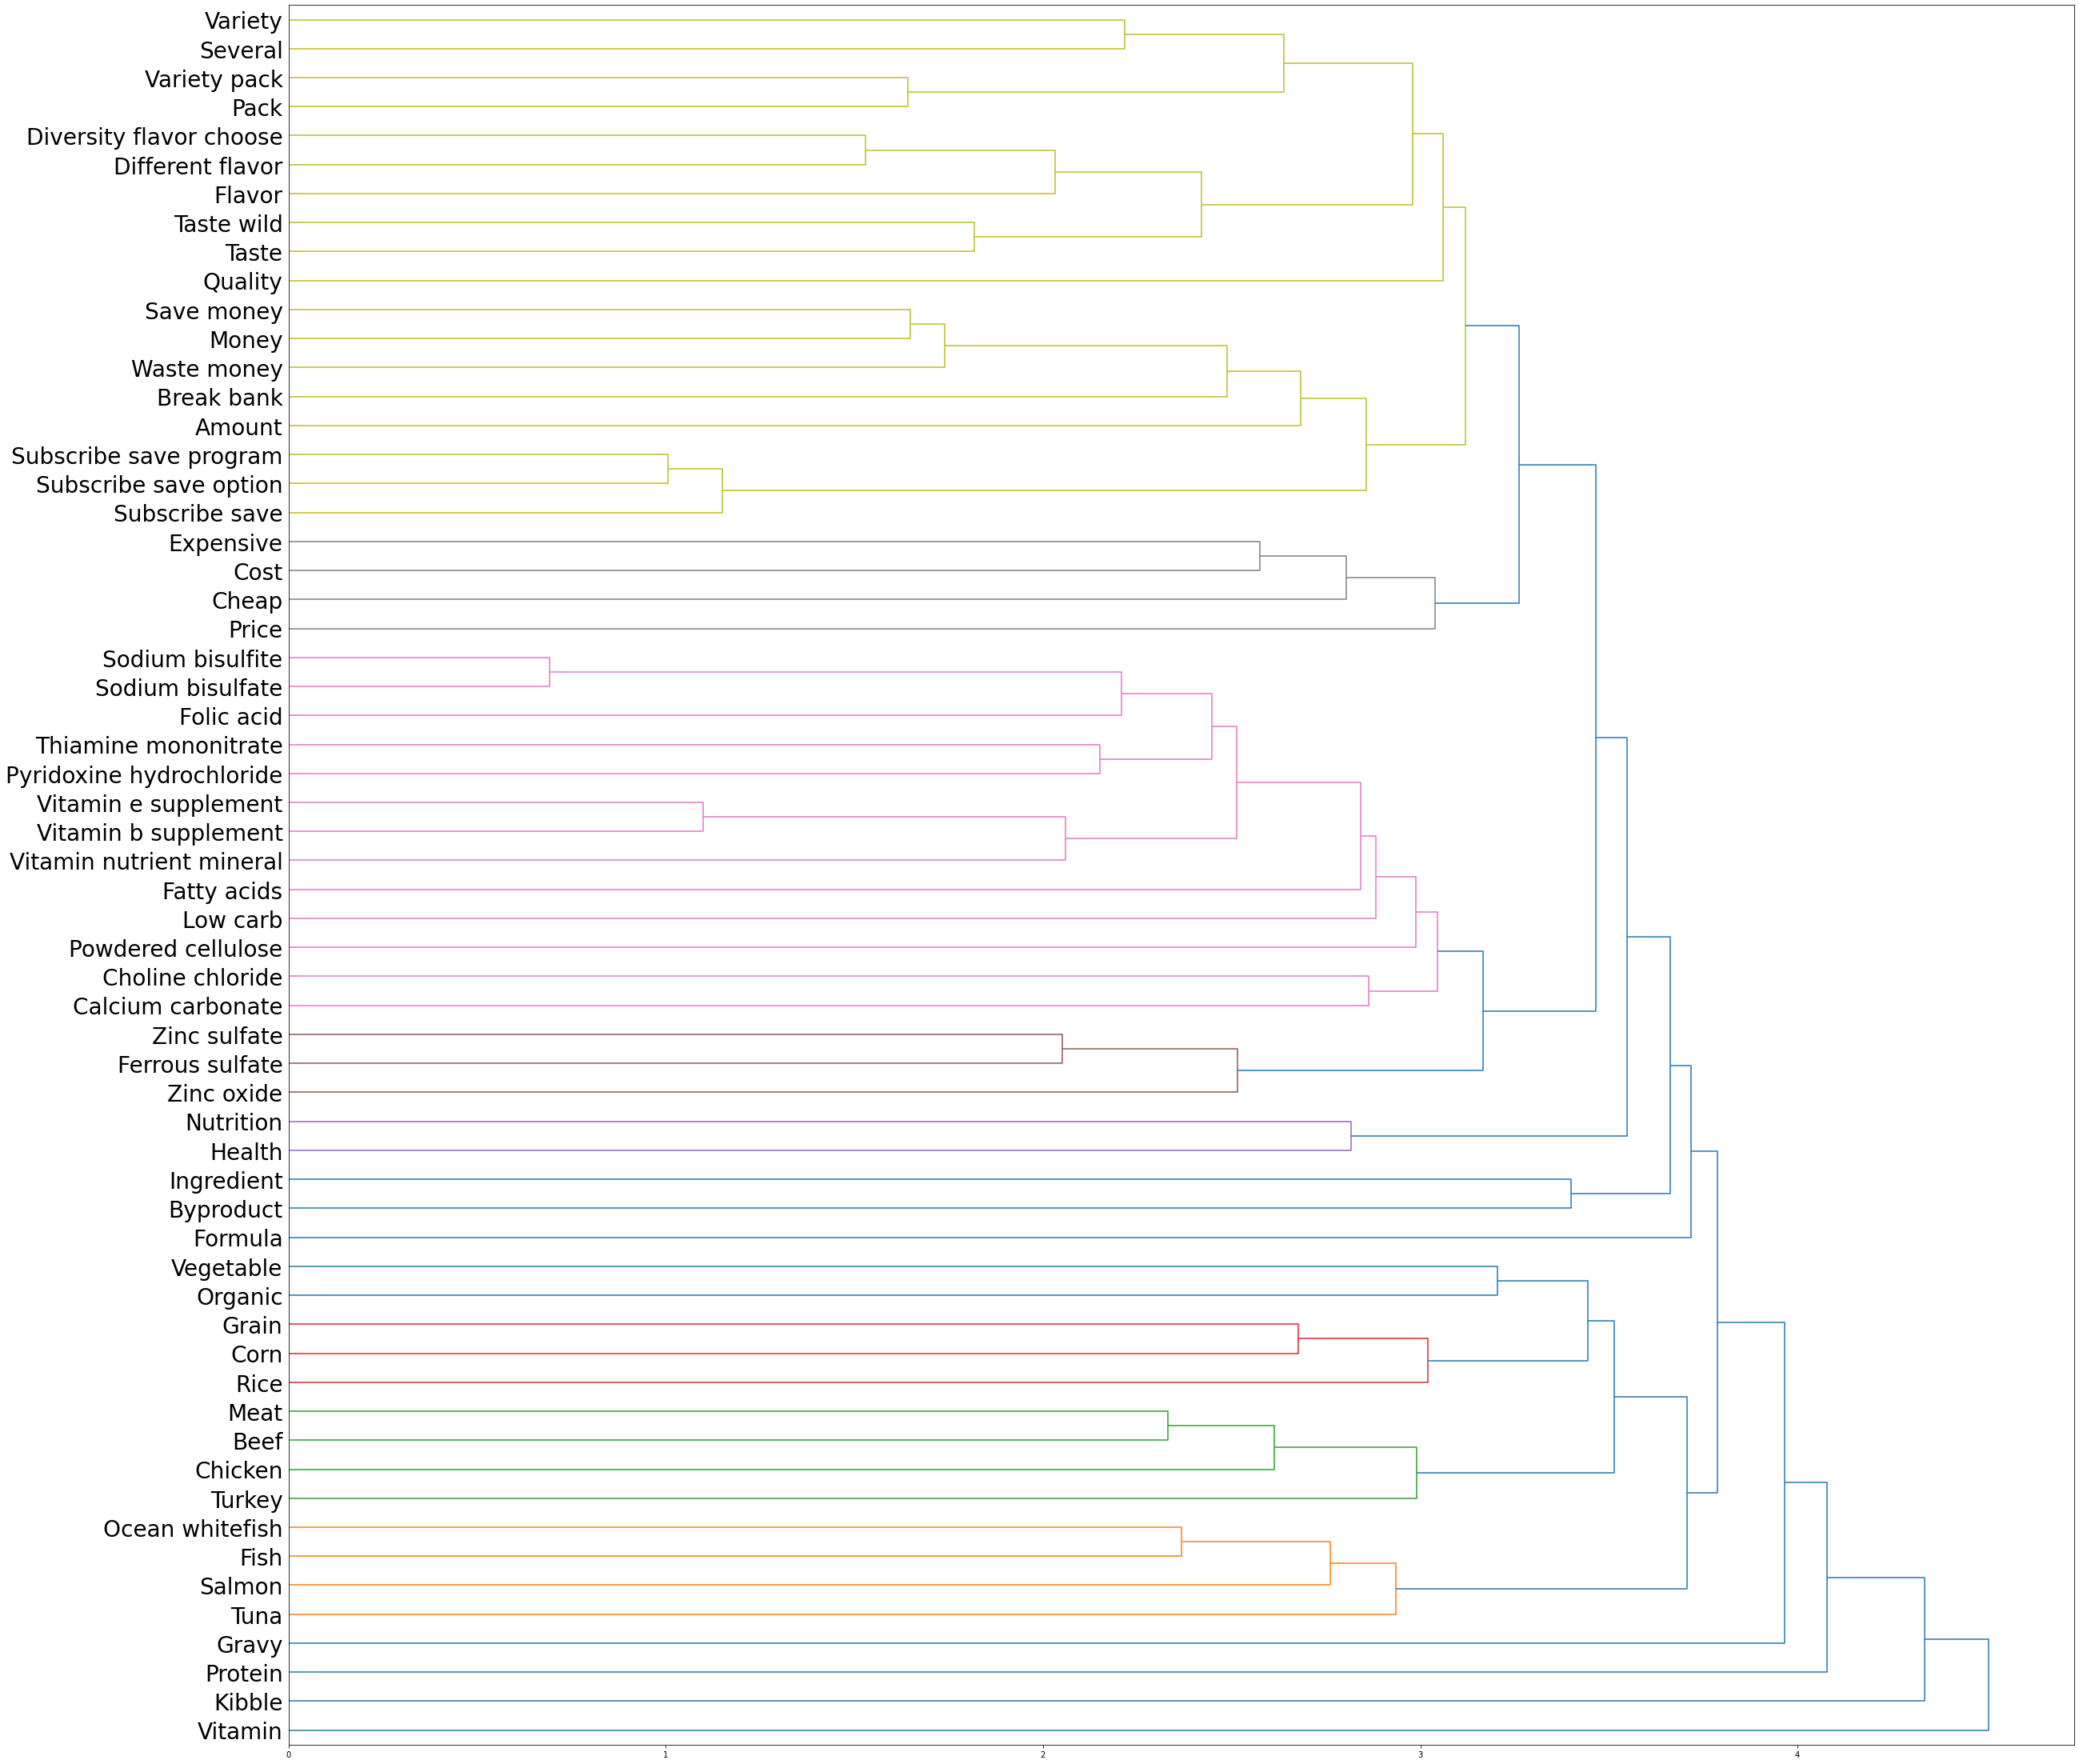

In [36]:
fig = plt.figure(figsize=(40, 40))
dn = dendrogram(Z, 
                orientation='right', 
                labels=list(vec_features_updated.keys()),
                #color_threshold = 4,
               leaf_font_size = 28) #cosine distance = 1 - consine similarity
plt.show()
fig.savefig('dedogram.png')

# step 4: sentence embeddings

In [37]:
# further clean tokens in review-level and sentence-level

In [56]:
cleaned_sens = pd.DataFrame([' '.join(sen) for sen in df1_dict['cleaned_tokens2']], columns = ['cleaned_sens'])

In [39]:
bigrams = [' '.join(x) for x in df1_dict['cleaned_bi_pmi2'][:120].bigram.values]
trigrams = [' '.join(x) for x in df1_dict['cleaned_tri_pmi2'][:120].trigram.values]

In [43]:
def further_clean(tokens, bigrams, trigrams):
    sens = re.sub(' +', ' ', ' '.join(tokens))
    connected_tokens = replace_ngram(sens, bigrams, trigrams)
    return connected_tokens

In [50]:
cleaned_sens.cleaned_sens = cleaned_sens.cleaned_sens.progress_apply(lambda x: further_clean(x.split(), bigrams, trigrams))

  0%|          | 0/27843 [00:00<?, ?it/s]

#### sentence level

In [111]:
with open ('./sents_df1.pickle', 'rb') as handle:
    sents_df1 = pickle.load(handle)

In [112]:
sents_df1 = sents_df1.progress_applymap(lambda x: '' if isinstance(x, list) and len(x) == 0 else x)

  0%|          | 0/1670580 [00:00<?, ?it/s]

In [113]:
token_columns = [c for c in sents_df1.columns if 'tokens' in c]
sents_df1[token_columns] = sents_df1[token_columns].progress_applymap(lambda x: ' '.join(x))

  0%|          | 0/835290 [00:00<?, ?it/s]

In [114]:
sents_df1[token_columns].head()

,Sentence1_tokens,Sentence2_tokens,Sentence3_tokens,Sentence4_tokens,Sentence5_tokens,Sentence6_tokens,Sentence7_tokens,Sentence8_tokens,Sentence9_tokens,Sentence10_tokens,...,Sentence21_tokens,Sentence22_tokens,Sentence23_tokens,Sentence24_tokens,Sentence25_tokens,Sentence26_tokens,Sentence27_tokens,Sentence28_tokens,Sentence29_tokens,Sentence30_tokens
0,find sale buy whim kitten omg go nuts hardwood...,,,,,,,,,,...,,,,,,,,,,
1,kittens crazy grow pay attention,play fetch,chase bring back long throw,carry around play,never see crazy,ten usually one end furniture,always seem locate one want one,overpriced piece plastic right worth,,,...,,,,,,,,,,
2,absolutely love spinner,carry around mouth toss around chase,far favorite,,,,,,,,...,,,,,,,,,,
3,tiny make lightweight plastic,give one minute chew ball tip choke,stay away,,,,,,,,...,,,,,,,,,,
4,buy think spinner basis hang curious playful p...,make parakeet toy yet vacillate kind string hang,evening spur moment decide stick individually ...,huge hit hour ago stop play,pick move around drop onto dish pick back even...,riot,,,,,...,,,,,,,,,,


In [115]:
sents_df1[token_columns] = sents_df1[token_columns].progress_applymap(lambda x: further_clean(x.split(), bigrams, trigrams))

  0%|          | 0/835290 [00:00<?, ?it/s]

In [117]:
with open ('./model/cleaned_sents_df1.pickle', 'wb') as handle:
    pickle.dump(sents_df1, handle)

In [158]:
with open ('./model/cleaned_sents_df1.pickle', 'rb') as handle:
    sents_df1 = pickle.load(handle)

## method 1: sentence2vec - gensim.doc2vec

In [127]:
# need to add all sentences to model

In [125]:
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(sents_df1[token_columns]['Sentence1_tokens'].values.tolist())]

In [126]:
# model = Doc2Vec(tagged_data, vector_size = 300, window = 2, min_count = 1, epochs = 100) #window = The maximum distance between the current and predicted word within a sentence.

In [ ]:
with open ('./model/gensim_d2v.pickle', 'wb') as handle:
    pickle.dump(model, handle)

In [128]:
with open ('./model/gensim_d2v.pickle', 'rb') as handle:
    model = pickle.load(handle)

In [ ]:
def cosine(u, v):
    return np.dot(u, v) / (np.lisimnalg.norm(u) * np.linalg.norm(v))

In [132]:
test_doc_vector = model.infer_vector(sents_df1[token_columns]['Sentence1_tokens'].values.tolist()[0].split())

In [133]:
test_doc_vector.shape

(300,)

## testing features: vitamin

In [134]:
test_feature = vec_features['vitamin']
test_feature = model.infer_vector(['vitamin'])

In [136]:
lst = model.docvecs.most_similar(positive = [test_feature], topn = 20)

In [137]:
sents_df1.Sentence1[[t[0] for t in lst]].values 

array(['Every cat needs their special vitamins!',
       "...because this is not supplemented w/vits or minerals it can only be used as a 'treat'.",
       'This food almost killed my cat.',
       'I had been supplementing dry cat food with canned.',
       'i have a 4 year old Maine Coon.',
       'My cat first sniffed it, then walked away.',
       "I'm very happy to be able to shop on line for Fancy Feast.",
       'I have an 18 year old cat with a very sensitive stomach.',
       'My cat has a sensitive tummy.',
       'So, five stars for the food itself.',
       'This is a complete and balanced diet.',
       'I have 3 glorious Maine Coons.', 'I just love my bravo treats.',
       'So convenient having the food delivered to my door!',
       'They sniff it and walk away.',
       'Our Maine Coons love this dry food.',
       'I recently have learned more about how a cat SHOULD eat.',
       'Our kitten has a sensitive stomach.',
       'I have a 3yr old and 12 yr old cat.',
    

## method2: sentence2vec - BERT 

In [141]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [146]:
sentence_embeddings = sbert_model.encode(sents_df1.Sentence1.values.tolist()) #feed into whole sentences - need to feed to whole corpus

In [149]:
with open ('./model/sentence_embeddings.pickle', 'wb') as handle:
    pickle.dump(sentence_embeddings, handle)

In [151]:
# with open ('./model/sentence_embeddings.pickle', 'rb') as handle:
#     sentence_embeddings = pickle.load(handle)

## testing features: value of money

In [152]:
feature_vec2 = sbert_model.encode('save money')

In [ ]:
# due to the computation, dont rerun them now
# sim_dict2 = {}
# for idx, sent in enumerate(sents_df1.Sentence1.values.tolist()):
#   sim = cosine(feature_vec2, sbert_model.encode([sent])[0])
#   sim_dict2[idx] = sim

In [ ]:
# sents_df1.Sentence1[list({k for k, v in sim_dict2.items() if v > 0.8})]

In [225]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

## Step 5: sentiment scoring

In [159]:
sentence_columns = [c for c in sents_df1.columns if not 'tokens' in c]

In [161]:
for col in sents_df1[sentence_columns].columns: #need to expand to whole sentences
    print(col)
    new_col = col + '_sentiment'
    sents_df1[new_col] = sents_df1[col].astype(str).apply(sid.polarity_scores)
    sents_df1[new_col] = sents_df1[new_col].apply(lambda x: x['compound'])

Sentence1
Sentence2
Sentence3
Sentence4
Sentence5
Sentence6
Sentence7
Sentence8
Sentence9
Sentence10
Sentence11
Sentence12
Sentence13
Sentence14
Sentence15
Sentence16
Sentence17
Sentence18
Sentence19
Sentence20
Sentence21
Sentence22
Sentence23
Sentence24
Sentence25
Sentence26
Sentence27
Sentence28
Sentence29
Sentence30


In [162]:
sentiment_columns = [c for c in sents_df1.columns if 'sentiment' in c]

In [166]:
scaler = MinMaxScaler(feature_range=(1,5))

for col in sents_df1[sentiment_columns].columns: #need to expand to whole sentences
    print(col)
    a = scaler.fit_transform(sents_df1[col].values.reshape(-1, 1))
    col_name = col + '_scaled'
    sents_df1[col_name] = a

Sentence1_sentiment
Sentence2_sentiment
Sentence3_sentiment
Sentence4_sentiment
Sentence5_sentiment
Sentence6_sentiment
Sentence7_sentiment
Sentence8_sentiment
Sentence9_sentiment
Sentence10_sentiment
Sentence11_sentiment
Sentence12_sentiment
Sentence13_sentiment
Sentence14_sentiment
Sentence15_sentiment
Sentence16_sentiment
Sentence17_sentiment
Sentence18_sentiment
Sentence19_sentiment
Sentence20_sentiment
Sentence21_sentiment
Sentence22_sentiment
Sentence23_sentiment
Sentence24_sentiment
Sentence25_sentiment
Sentence26_sentiment
Sentence27_sentiment
Sentence28_sentiment
Sentence29_sentiment
Sentence30_sentiment


## Step 6: link sentence to product attributes, and aggregate the sentiment scoring (selected products for demo)

In [168]:
df1.columns #asin

Index(['Unnamed: 0', 'reviewerID', 'asin', 'reviewerName', 'helpful',
       'reviewText', 'overall', 'summary', 'unixReviewTime', 'reviewTime',
       'related', 'title', 'price', 'salesRank', 'imUrl', 'brand',
       'categories', 'description', 'category_1', 'category_2', 'category_3',
       'category_4', 'category_5'],
      dtype='object')

In [197]:
df1 = df1.reset_index(drop = True)

In [198]:
sents_df1['asin'] = df1['asin']
sents_df1['rating'] = df1['overall']

In [200]:
num_reviews = sents_df1.groupby('asin').size()
pd.DataFrame(num_reviews).reset_index()
avg_ratings = sents_df1.groupby('asin')['rating'].mean()
pd.DataFrame(avg_ratings).reset_index()
combined = pd.concat([pd.DataFrame(num_reviews).reset_index(), pd.DataFrame(avg_ratings).reset_index(drop = True)], axis = 1)
combined.columns = ['asin', 'num_reviews','rating']
combined.sort_values(['num_reviews', 'rating'], ascending = [False, True]).head(20)

,asin,num_reviews,rating
599,B0012KB46Q,640,4.542187
914,B001TLY70S,356,4.132022
1103,B002CJAOJY,292,4.116438
389,B000O2APH2,285,3.996491
468,B000VK4K3W,268,3.992537
674,B001709GF2,251,4.235060
911,B001STX13U,249,4.550201
732,B0018CJYCO,236,4.483051
504,B000WFKWDI,230,4.056522
320,B000HBF3HC,208,4.471154


### product 1

In [201]:
product1 = sents_df1[sents_df1.asin == 'B002OHOC6A']

In [256]:
product1 = product1.reset_index(drop = True)

In [203]:
set(df1[df1.asin == 'B002OHOC6A']['description'].tolist())

{'Give your cat the nutrition he needs every day, in every lifestage. 9Lives Daily Essentials cat food delivers nutrition that helps support healthy heart, clear vision, strong muscles and healthy skin and coat.'}

In [210]:
sents_df1[sents_df1.asin == 'B002OHOC6A'].rating.mean()

3.861111111111111

In [226]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [228]:
sim_dict2 = {}
for col in tqdm(product1[sentence_columns]):
    for idx, sent in enumerate(product1[col].values.tolist()):
        key_nme = col + '_' + str(idx) 
        sim = cosine(feature_vec2, sbert_model.encode([sent])[0])
        sim_dict2[key_nme] = sim

  0%|          | 0/36 [00:00<?, ?it/s]

In [230]:
sorted_sim_dict = {k: v for k, v in sorted(sim_dict2.items(), key=lambda item: item[1], reverse=True)}

In [242]:
returned_lst = list({(k.split('_')[0], k.split('_')[1]) for k, v in sim_dict2.items() if v > 0.6})

In [263]:
for idx, vle in enumerate(returned_lst):
    print(product1.iloc[int(vle[1])][vle[0]])

Great product to buy.
I liked the value size of the bag.
But the price ended up going up and it ended up being cheaper just getting it at the store.
I figure it's all pretty decent so why not save a little money...
I was looking for something cheap so I guess you get what you pay for.
That's pretty much all you expect.
As always, shipping was quick, packaged well.
In my opinion, it's the best.
Can always find better deal if you chose to look.
For the money it is a great product.
Thought i was getting good deal, but that's that.
This product is fantastic.
We like to purchase the larger sized bag, as it's cheaper than smaller bags.
Its a good product.
And the colors pattern was cute.
It's one of the better brands out there.


In [268]:
np.mean([product1.iloc[int(vle[1])][vle[0] + '_sentiment_scaled'] for idx, vle in enumerate(returned_lst)])

3.757054523574148